In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import time
import scipy.optimize

In [18]:
#Equation
def physics_net(net, xt):
    x = xt[:, 0:1]
    t = xt[:, 1:2]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        tape.watch(x)
        xt_t = tf.concat([x,t], axis=1)
        u = net(xt_t)
    u_x = tape.gradient(u, x)
    u_t = tape.gradient(u, t)

    return u_t - 3*u_x

In [19]:
#MSE = MSE_u + MSE_f
def compute_loss(f, u_bnd_hat, u_bnd_sol):

    loss_col = tf.reduce_mean(tf.square(f))
    loss_bnd = tf.reduce_mean(tf.square(u_bnd_hat[100:200]-u_bnd_hat[200:300]))
    loss_ini = tf.reduce_mean(tf.square(u_bnd_hat[:100]-u_bnd_sol[:100]))
    
    loss = loss_col + loss_bnd + loss_ini

    return loss

In [20]:
def compute_grad(net, xt_col, xt_bnd, u_bnd_sol):
    with tf.GradientTape() as tape:
        f = physics_net(net,xt_col)
        u_bnd_hat = net(xt_bnd)

        loss = compute_loss(f, u_bnd_hat, u_bnd_sol)

    grads = tape.gradient(loss, net.trainable_variables) #gradients 계산

    return loss, grads

In [21]:
#어떤 이벤트가 발생했거나 특정 시점에 도달했을 때 시스템에서 호출하는 함수
def callback(arg=None):
    global iter_num
    global instant_loss
    if iter_num % 100 == 0:
        print('iter=', iter_num, ', loss=', instant_loss)
    #train_loss_history.append([iter_num, instant_loss])

    iter_num=iter_num+1

In [22]:
def transport_data():

    # set number of data points
    N_b = 100    # boundary
    N_t = 100    # initial time
    N_c = 10000  # collocation point

    # set boundary
    xmin = -1.0
    xmax = 1.0
    tmin = 0.0
    tmax = 1.0

    # initial condition
    initial_xt = np.linspace([xmin, tmin], [xmax, tmin], N_t)
    initial_u = (1-np.sin(np.pi * initial_xt[:,0])).reshape(-1,1)

    # boundary condition
    boundary_up = np.linspace([xmax, tmin], [xmax, tmax], N_b)
    boundary_up_sol = np.array([1-np.sin(np.pi*(1+3*boundary_up[:, 1][i])) for i in range(N_b)]).reshape(-1, 1)
    boundary_down = np.linspace([xmin, tmin], [xmin, tmax], N_b)
    boundary_down_sol = np.array([1-np.sin(np.pi*(-1+3*boundary_down[:, 1][i])) for i in range(N_b)]).reshape(-1, 1)

    # collection of initial and boundary condition
    xt_bnd = np.concatenate([initial_xt, boundary_up, boundary_down], axis=0)
    u_bnd_sol = np.concatenate([initial_u, boundary_up_sol, boundary_down_sol], axis=0)


    # collocation point
    t_col_data = np.random.uniform(tmin, tmax, [N_c, 1])
    x_col_data = np.random.uniform(xmin, xmax, [N_c, 1])
    xt_col_data = np.concatenate([x_col_data, t_col_data], axis=1)
    xt_col = np.concatenate((xt_col_data, xt_bnd), axis=0)

    # convert all to tensors
    xt_col = tf.convert_to_tensor(xt_col, dtype=tf.float32)
    xt_bnd = tf.convert_to_tensor(xt_bnd, dtype=tf.float32)
    u_bnd_sol = tf.convert_to_tensor(u_bnd_sol, dtype=tf.float32)

    return xt_col, xt_bnd, u_bnd_sol

In [23]:
iter_num=1
instant_loss=0
train_loss_history=[]

In [24]:
def save_weights_lbfgs(net):
    net.save_weights('transport.h5')

def load_weights_lbfgs(net):
    net.load_weights('transport.h5')

In [25]:
initializer = tf.keras.initializers.GlorotUniform #모델의 초기의 가중치 값 설정(균등분포)
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((None,2)),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 1, activation='linear')
])

NN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, None, 20)          60        
                                                                 
 dense_11 (Dense)            (None, None, 20)          420       
                                                                 
 dense_12 (Dense)            (None, None, 20)          420       
                                                                 
 dense_13 (Dense)            (None, None, 20)          420       
                                                                 
 dense_14 (Dense)            (None, None, 20)          420       
                                                                 
 dense_15 (Dense)            (None, None, 20)          420       
                                                                 
 dense_16 (Dense)            (None, None, 20)         

In [26]:
def train_with_lbfgs(net, xt_col, xt_bnd, u_bnd_sol, lbfgs_num):
    def vec_weight():
        #모델에서 학습되는 가중치들을 추출
        return weight_vec
    w0 = vec_weight().numpy()
    
    def restore_weight(weight_vec):
        #위의 함수에서 구한 가중치들 중에서 기울기와 절편을 따로 분리
        
    def loss_grad(w):
        #손실값과 가중치를 반환
        return loss, grad_vec
    
    return scipy.optimize.minimize(fun=loss_grad, #The objective function to be minimized
                                    x0=w0, #Array of real elements of size (n,) as Initial guess
                                    jac=True, 
                                    method='L-BFGS-B',
                                    callback=callback,
                                    options={'maxiter': lbfgs_num})

IndentationError: expected an indented block (2415812090.py, line 10)

In [27]:
#L-BFGS기법을 사용하여 gradients를 통해 backpropagation(weight 갱신)을 진행
def train_with_lbfgs(net, xt_col, xt_bnd, u_bnd_sol, lbfgs_num):

    def vec_weight():
        # vectorize weights
        weight_vec = []

        # Loop over all weights(위에서 만든 신경망 NN의 layers의학습 가능한 가중치_weight,biasis)
        for v in net.trainable_variables:
            weight_vec.extend(v.numpy().flatten())

        weight_vec = tf.convert_to_tensor(weight_vec)
        return weight_vec
    w0 = vec_weight().numpy()

    def restore_weight(weight_vec):
        # restore weight vector to model weights
        idx = 0
        for v in net.trainable_variables:
            vs = v.shape

            # weight matrices
            if len(vs) == 2:
                sw = vs[0] * vs[1]
                updated_val = tf.reshape(weight_vec[idx:idx + sw], (vs[0], vs[1]))
                idx += sw

            # bias vectors
            elif len(vs) == 1:
                updated_val = weight_vec[idx:idx + vs[0]]
                idx += vs[0]

            # assign variables (Casting necessary since scipy requires float64 type)
            v.assign(tf.cast(updated_val, dtype=tf.float32))


    def loss_grad(w):
        # update weights in model
        restore_weight(w)
        loss, grads = compute_grad(net, xt_col, xt_bnd, u_bnd_sol)
        # vectorize gradients
        grad_vec = []
        for g in grads:
            grad_vec.extend(g.numpy().flatten())

        # gradient list to array
        # scipy-routines requires 64-bit floats
        loss = loss.numpy().astype(np.float64)
        global instant_loss
        instant_loss = loss
        grad_vec = np.array(grad_vec, dtype=np.float64)

        return loss, grad_vec
    
    return scipy.optimize.minimize(fun=loss_grad, #The objective function to be minimized
                                    x0=w0, #Array of real elements of size (n,) as Initial guess
                                    jac=True, 
                                    method='L-BFGS-B',
                                    callback=callback,
                                    options={'maxiter': lbfgs_num,
                                             'disp': True})

In [28]:
def train(net, lbfgs_num):

    xt_col, xt_bnd, u_bnd_sol = transport_data()

    #start time
    t1 = time.time()
    train_with_lbfgs(net, xt_col, xt_bnd, u_bnd_sol, lbfgs_num)
    # Print computation time
    print('\nComputation time of L-BFGS-B: {} seconds'.format(time.time() - t1))

    save_weights_lbfgs(net)
    
    #global train_loss_history
    #np.savetxt('loss_lbfgs.txt', train_loss_history)
    #train_loss_history = np.array(train_loss_history)

    #plt.plot(train_loss_history[:, 0], train_loss_history[:, 1])
    #plt.yscale("log")
    #plt.show()

In [29]:
lbfgs_num = 4000
train(NN, lbfgs_num)

iter= 100 , loss= 0.0315740630030632
iter= 200 , loss= 0.015957389026880264
iter= 300 , loss= 0.009726827964186668
iter= 400 , loss= 0.0010849955724552274
iter= 500 , loss= 0.0001783521584002301
iter= 600 , loss= 9.440377471037209e-05
iter= 700 , loss= 4.670742782764137e-05
iter= 800 , loss= 3.078299414482899e-05
iter= 900 , loss= 2.1238127374090254e-05
iter= 1000 , loss= 1.4203087630448863e-05
iter= 1100 , loss= 1.0017510248871986e-05

Computation time of L-BFGS-B: 97.62328958511353 seconds


In [47]:
import numpy as np
t = np.linspace(0, 1, 100)
x = np.linspace(-1, 1, 100)

ex = []

pre_xt = []

for i in range(100):
    for s in range(100):
        pre_xt.append([x[s], t[i]])
        ex.append(1-np.sin(np.pi*(x[s] + 3*t[i])))

exact = np.array(ex).reshape(100, 100)

pre_xt = np.array(pre_xt)
pre_u = NN.predict(pre_xt)
pre = pre_u.reshape(100, 100)

313/313 [==============================] - 1s 2ms/step


In [48]:
#relative_L2_error
round((np.linalg.norm(exact-pre, 2))/(np.linalg.norm(exact, 2)), 10)

0.00084526

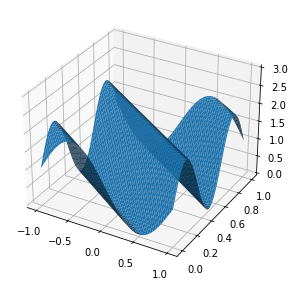

In [49]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = np.array([x for i in range(100)])
Y = np.array([t for i in range(100)]).T
Z = exact

ax.plot_surface(X, Y, Z)
ax.set_zlim(0, 3)

plt.tight_layout()
plt.show()

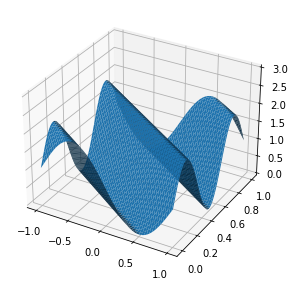

In [50]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = np.array([x for i in range(100)])
Y = np.array([t for i in range(100)]).T
Z = pre

ax.plot_surface(X, Y, Z)
ax.set_zlim(0, 3)

plt.tight_layout()
plt.show()

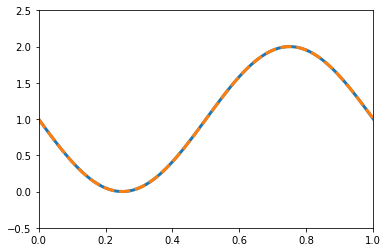

In [52]:
# 그래프 애니메이션

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
fig, ax = plt.subplots()

ax.set_xlim(( 0, 1))
ax.set_ylim((-0.5, 2.5))

line1, = ax.plot([], [], lw=3)
line2, = ax.plot([], [], lw=3, linestyle = '--')

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return (line1, line2,)

def animate(i):
    x = np.linspace(0, 1, 100)
    y = exact[i]
    line1.set_data(x, y)
    line2.set_data(x, pre[i])
    return (line1,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=40, blit=True)

rc('animation', html='html5')
anim.save('transport.gif', writer='imagemagick')
anim

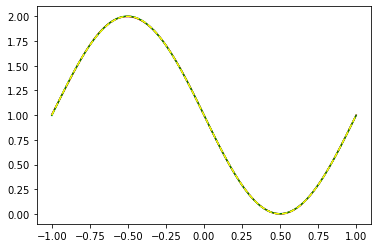

In [54]:
plt.plot(x, pre[0], color="red")
plt.plot(x, exact[0], color="blue", linestyle = '--')
plt.plot(x, pre[66], color="green")
plt.plot(x, exact[66], color="yellow", linestyle = '--')

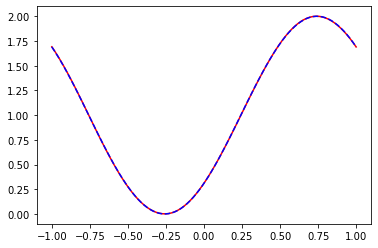

In [55]:
plt.plot(x, pre[25], color="red")
plt.plot(x, exact[25], color="blue", linestyle = '--')

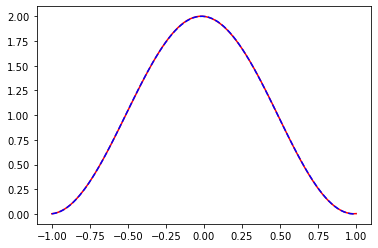

In [56]:
plt.plot(x, pre[50], color="red")
plt.plot(x, exact[50], color="blue", linestyle = '--')

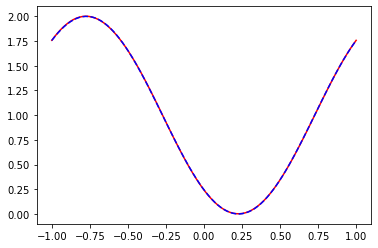

In [57]:
plt.plot(x, pre[75], color="red")
plt.plot(x, exact[75], color="blue", linestyle = '--')

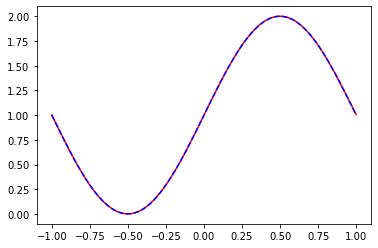

In [58]:
plt.plot(x, pre[-1], color="red")
plt.plot(x, exact[-1], color="blue", linestyle = '--')